## Problem Statement

Based on the dataset where we have to classify the cellular localization sites of proteins. Here we are working on the dataset with various features which are the dimensions and singles given by the business we have to create the classification algorithm using support vector machine

**Data Dictionary**

**Sequence Name** - Accession number for the SWISS-PROT database

**mcg** - McGeoch's method for signal sequence recognition

**gvh** - von Heijne's method for signal sequence recognition

**alm** - Score of the ALOM membrane spanning region prediction program

**mit** - Score of discriminant analysis of the amino acid content of the N-terminal region (20 residues long) of mitochondrial and non-mitochondrial proteins

**erl** - Presence of "HDEL" substring (thought to act as a signal for retention in the endoplasmic reticulum lumen). Binary attribute

**pox** - Peroxisomal targeting signal in the C-terminus.

**vac** - Score of discriminant analysis of the amino acid content of vacuolar and extracellular proteins.

**nuc** - Score of discriminant analysis of nuclear localization signals of nuclear and non-nuclear proteins.

**YeastType** - This is the dependent variable

# Table of Content

1. **[Import Libraries](#lib)**
2. **[Data Preparation](#prep)**
    - 2.1 - **[Understand the Data](#read)**
    - 2.2 - **[Exploratory Data Analysis](#eda)**
    - 2.3 - **[Missing Value Treatment](#null)**
    - 2.4 - **[Encoding and Feature Scaling](#enc)**
3. **[What is Support Vector Machine](#lr)**
    - 3.1 - **[Types of Kernel](#gi)**
    - 3.2 - **[Where to use which kernel](#mf)**
    - 3.3 - **[Different Hyper parameters for different kernels](#sf)**
    - 3.4 - **[How the value of C, Gamma will impact the model (Overfitting and Underfitting) ](#wknn)**
4. **[Splitting the data into Train and Test](#sd)**
5. **[Creating the model on training dataset](#model)**
6. **[Run the model on the Test Dataset](#test)**
7. **[Check the accuracy of the model](#acc)**
    - 7.1 - **[Accuracy Score](#accscore)**
    - 7.2 - **[Confusion Matrix](#cm)**
    - 7.3 - **[ROC Curve](#roc)**
    - 7.4 - **[F1 Score](#f1score)**
    - 7.5 - **[Log Loss](#logloss)**
8. **[Comparing the Training and Testing Accuracies](#overunder)**
9. **[Applying Grid Search Cross Validation to find the best value of Hyper Parameters](#kfcv)**

<a id="lib"></a>
# 1. Import Libraries

In [2]:
#Importing the libraries which will be helpful for the data analysis. 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import os 

<a id="prep"></a>
# 2. Data Preparation

In [3]:
#Importing the dataset which we will use for the modelling 
os.chdir(r'C:\Users\rahul\OneDrive\Desktop\Case Studies - KWH\Case Study - Support Vector Machine')
dataset = pd.read_csv('Yeast_Data.csv')

<a id="read"></a>
# 2.1. Understand the Data

In [4]:
#Here are the few commands which will help us to understand the basic data 
#The info command will help us to understand the different columns present in the dataset and its datatype
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SequenceName  892 non-null    object 
 1   MCG           892 non-null    float64
 2   GVH           892 non-null    float64
 3   ALM           892 non-null    float64
 4   MIT           892 non-null    float64
 5   ERL           892 non-null    float64
 6   POX           892 non-null    float64
 7   VAC           892 non-null    float64
 8   NUC           892 non-null    float64
 9   YeastType     892 non-null    object 
dtypes: float64(8), object(2)
memory usage: 69.8+ KB


In [5]:
#Len command will help us understand the total number of records present in the dataset
len(dataset)

892

In [6]:
#.columns command will help us understand the columns present in the dataset
dataset.columns

Index(['SequenceName', 'MCG', 'GVH', 'ALM', 'MIT', 'ERL', 'POX', 'VAC', 'NUC',
       'YeastType'],
      dtype='object')

In [7]:
#The below command will help us understand the total number of columns present in the dataset
len(dataset.columns)

10

<a id="eda"></a>
# 2.2. Exploratory Data Analysis

<Figure size 1500x200 with 0 Axes>

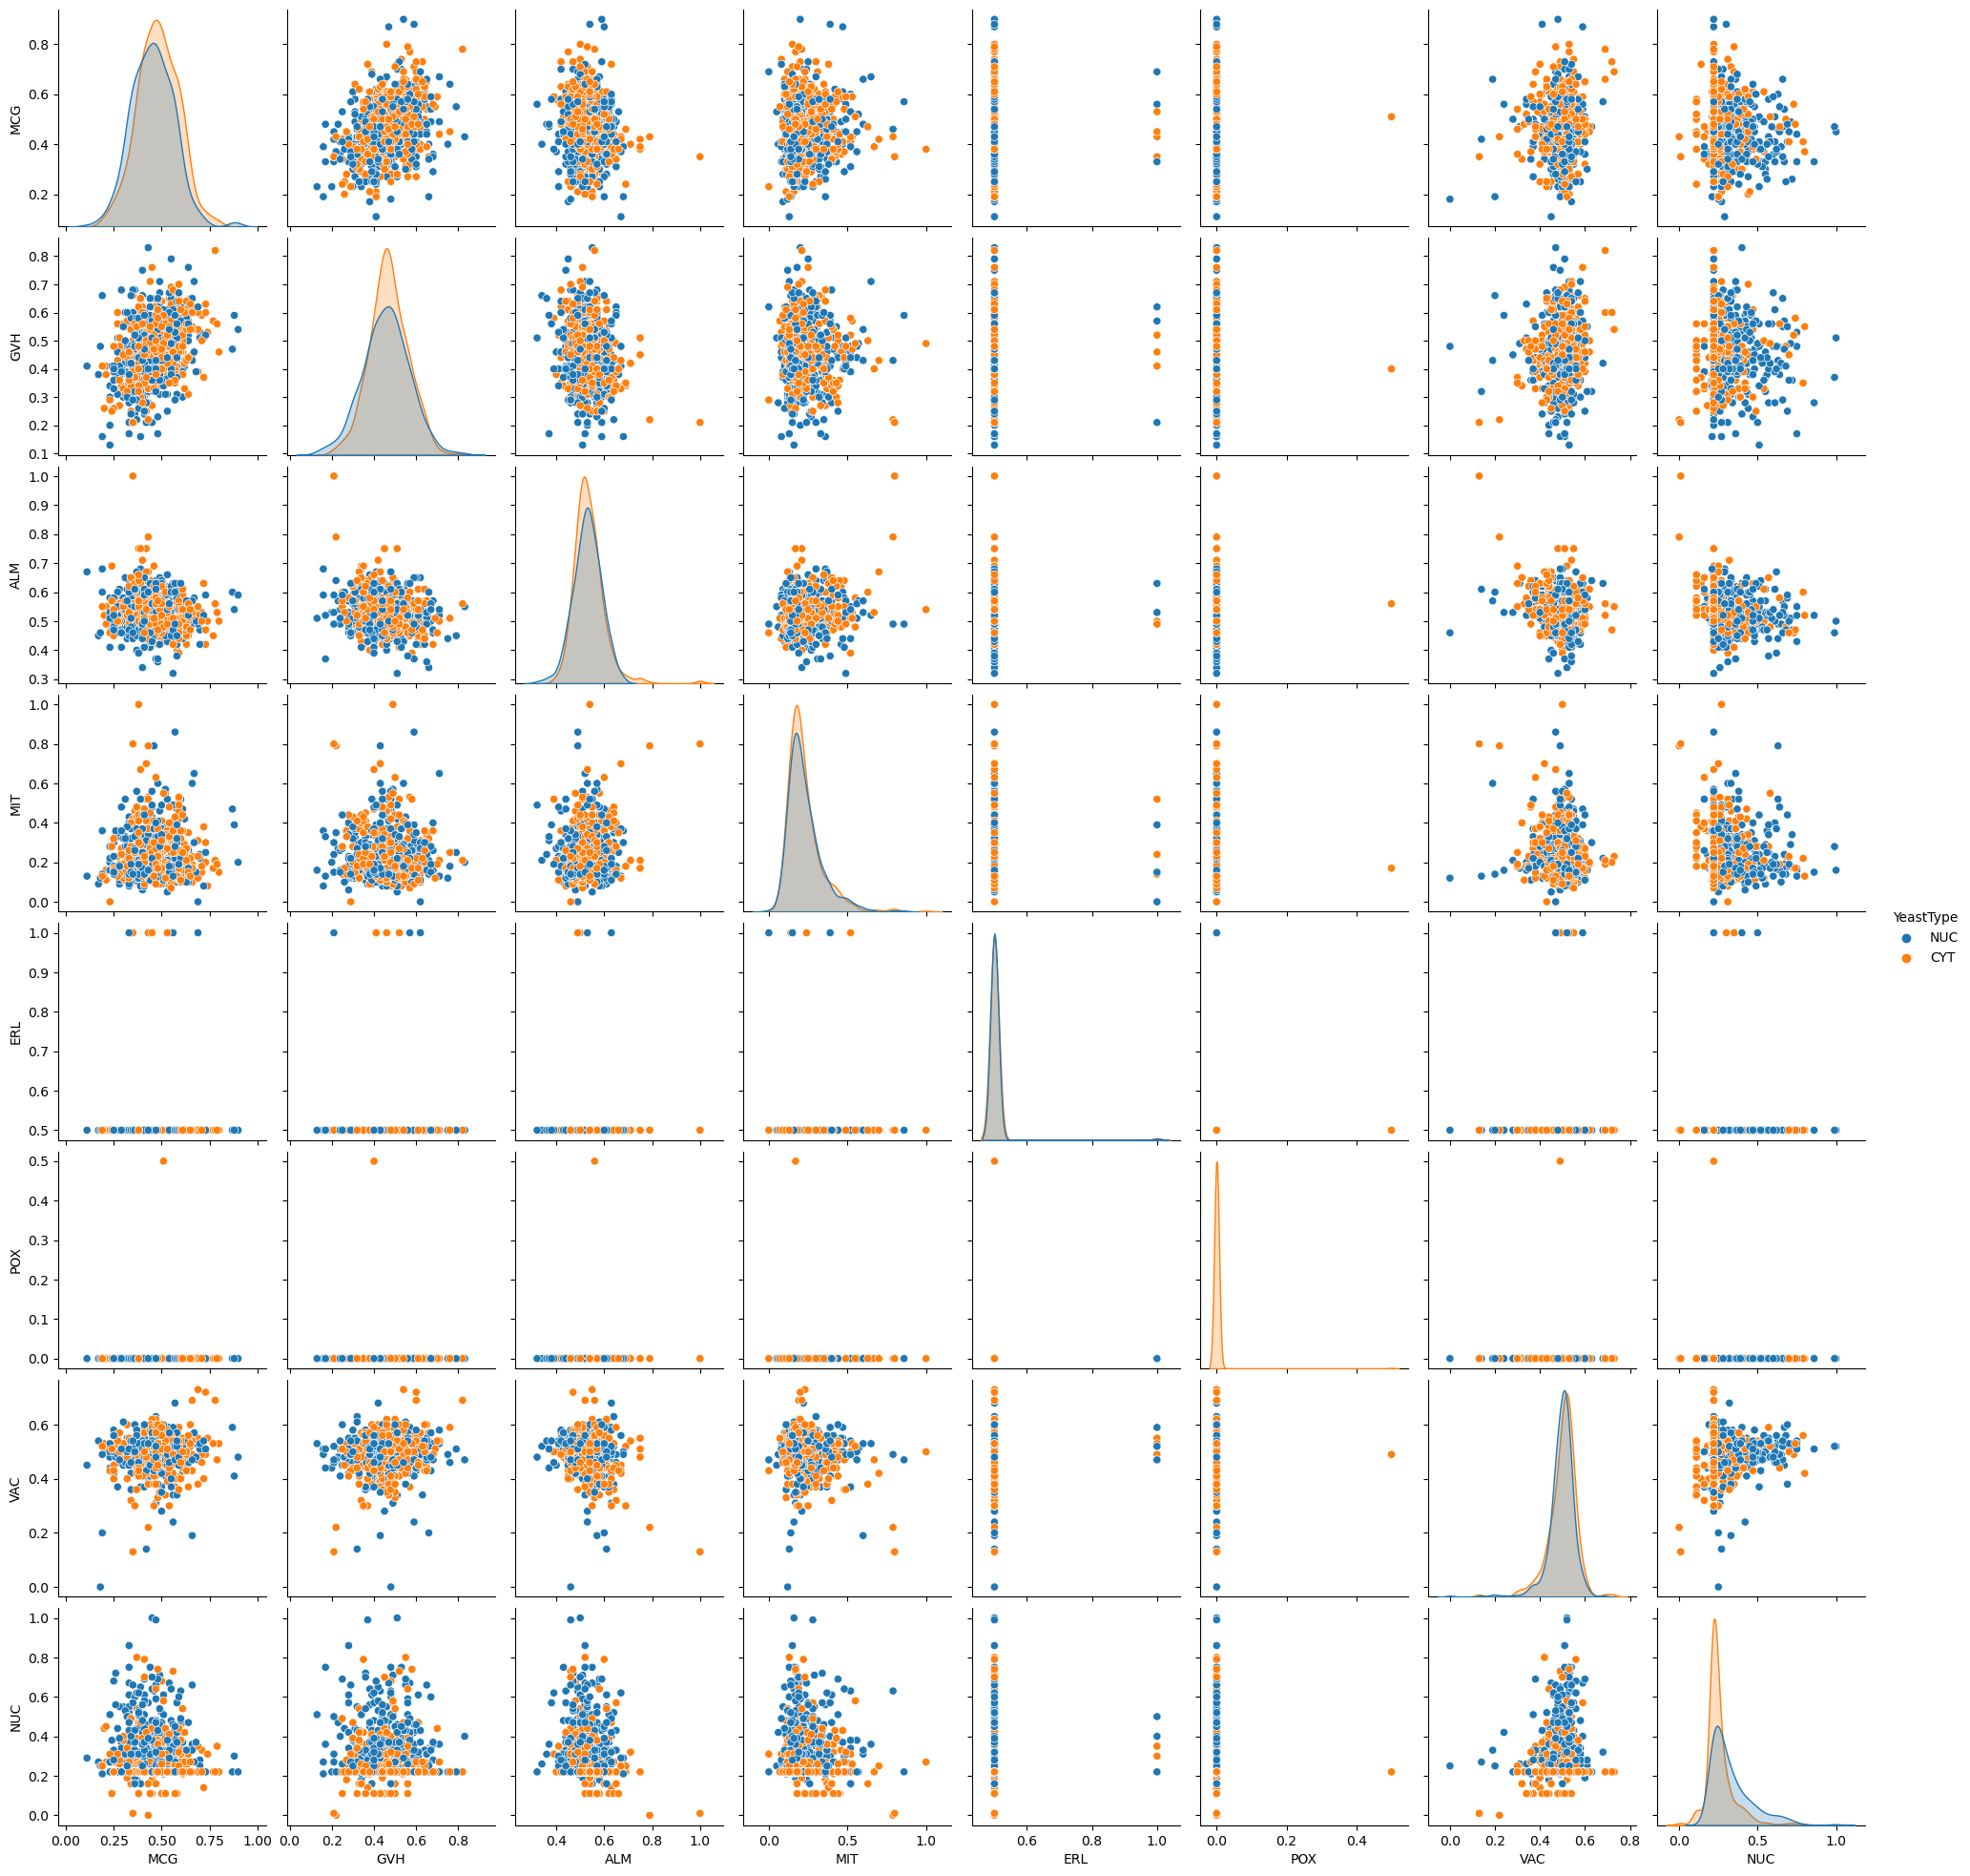

In [8]:
plt.figure(figsize=(15,2))
sns.pairplot(dataset[['MCG', 'GVH', 'ALM', 'MIT', 'ERL', 'POX', 'VAC', 'NUC','YeastType']],hue='YeastType')
plt.show()

**From the above chart there is no significant outcome which can tell us that the numerical features are important for predicting the yeast type**

<a id="null"></a>
# 2.3. Missing Value Treatment

In [9]:
#Checking the count of the missing values percentage, there are very few missing values there in the dataset
dataset.isnull().sum()/len(dataset)*100

SequenceName    0.0
MCG             0.0
GVH             0.0
ALM             0.0
MIT             0.0
ERL             0.0
POX             0.0
VAC             0.0
NUC             0.0
YeastType       0.0
dtype: float64

In [10]:
#Missing Value Imputation - We can impute the missing values using the methods of mean, median and mode based on the various scenarios
#When there is a numerical field we can populate the missing values using mean or median, 
#if there are outliers in the dataset we use to populate the missing values using median else mean
#When we want to populate the missing values in the categorial files we go with mode as an option

<a id="enc"></a>
# 2.4. Encoding and Feature Scaling

In [11]:
# Separating the numerical and categorical columns
from sklearn.preprocessing import StandardScaler
def data_type(dataset):
    """
    Function to identify the numerical and categorical data columns
    :param dataset: Dataframe
    :return: list of numerical and categorical columns
    """
    numerical = []
    categorical = []
    for i in dataset.columns:
        if dataset[i].dtype == 'int64' or dataset[i].dtype == 'float64':
            numerical.append(i)
        else:
            categorical.append(i)
    return numerical, categorical


numerical, categorical = data_type(dataset)

# Identifying the binary columns and ignoring them from scaling
def binary_columns(df):
    """
    Generates a list of binary columns in a dataframe.
    """
    binary_cols = []
    for col in df.select_dtypes(include=['int', 'float']).columns:
        unique_values = df[col].unique()
        if np.in1d(unique_values, [0, 1]).all():
            binary_cols.append(col)
    return binary_cols

binary_cols = binary_columns(dataset)

# Remove the binary columns from the numerical columns
numerical = [i for i in numerical if i not in binary_cols]

def encoding(dataset, categorical):
    """
    Function to automate the process of encoding the categorical data
    :param dataset: Dataframe
    :param categorical: List of categorical columns
    :return: Dataframe
    """
    for i in categorical:
        dataset[i] = dataset[i].astype('category')
        dataset[i] = dataset[i].cat.codes
    return dataset

dataset = encoding(dataset, categorical)

def feature_scaling(dataset, numerical):
    """
    Function to automate the process of feature scaling the numerical data
    :param dataset: Dataframe
    :param numerical: List of numerical columns
    :return: Dataframe
    """
    sc_x = StandardScaler()
    dataset[numerical] = sc_x.fit_transform(dataset[numerical])
    return dataset

dataset = feature_scaling(dataset, numerical)

In [12]:
dataset

,SequenceName,MCG,GVH,ALM,MIT,ERL,POX,VAC,NUC,YeastType
0,2,1.026911,-0.228006,0.607699,-0.868168,-0.088936,-0.033501,0.691290,-0.597676,1
1,3,0.390102,-0.623306,0.445695,-0.512732,-0.088936,29.849623,-0.109737,-0.597676,0
2,42,0.117184,-0.129181,0.931709,-0.246155,-0.088936,-0.033501,1.332111,0.384292,1
3,4,-0.610599,-0.722131,1.093713,-0.690450,-0.088936,-0.033501,1.332111,0.056970,0
4,5,-0.337680,-0.722131,0.121685,-0.157296,-0.088936,-0.033501,0.531084,-0.188522,1
...,...,...,...,...,...,...,...,...,...,...
887,493,-0.792544,-1.413906,1.741732,1.619882,-0.088936,-0.033501,-0.910764,-1.497813,0
888,494,-0.792544,-0.623306,2.065742,1.086729,-0.088936,-0.033501,-1.070969,-1.497813,0
889,868,0.026211,-0.326831,1.255718,1.531023,-0.088936,-0.033501,-0.269942,1.448091,1
890,869,-0.337680,-0.623306,1.093713,-0.601591,-0.088936,-0.033501,0.531084,0.793446,1


<a id="lr"></a>
# 3. What is Support Vector Machine

Support Vector Machine or SVM is one of the most popular Supervised Learning algorithms, which is used for Classification.

The goal of the SVM algorithm is to create the decision boundary that can segregate n-dimensional space into classes so that we can easily put the new data point in the correct category in the future. This best decision boundary is called a hyperplane.

SVM chooses the extreme points/vectors that help in creating the hyperplane. These extreme cases are called as support vectors, and hence algorithm is termed as Support Vector Machine.

We can use various kernels which we can use in the various scenarios.

<a id="gi"></a>
# 3.1. Types of Kernels

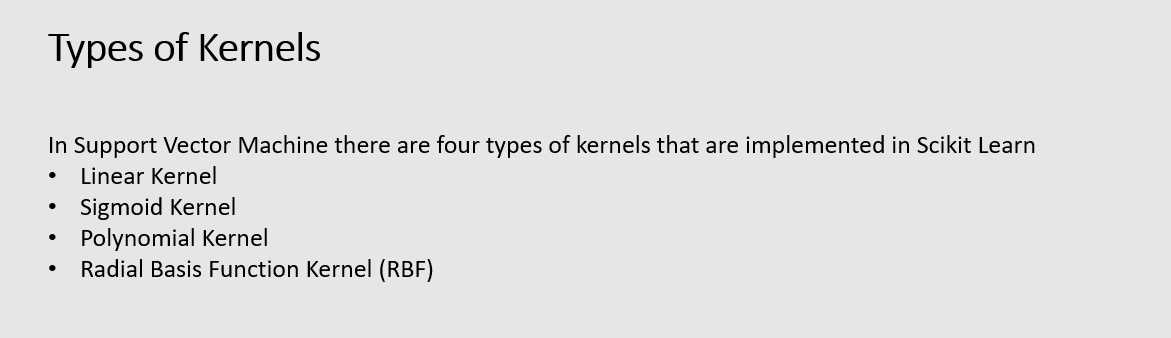

<a id="mf"></a>
# 3.2. Where to use which kernel

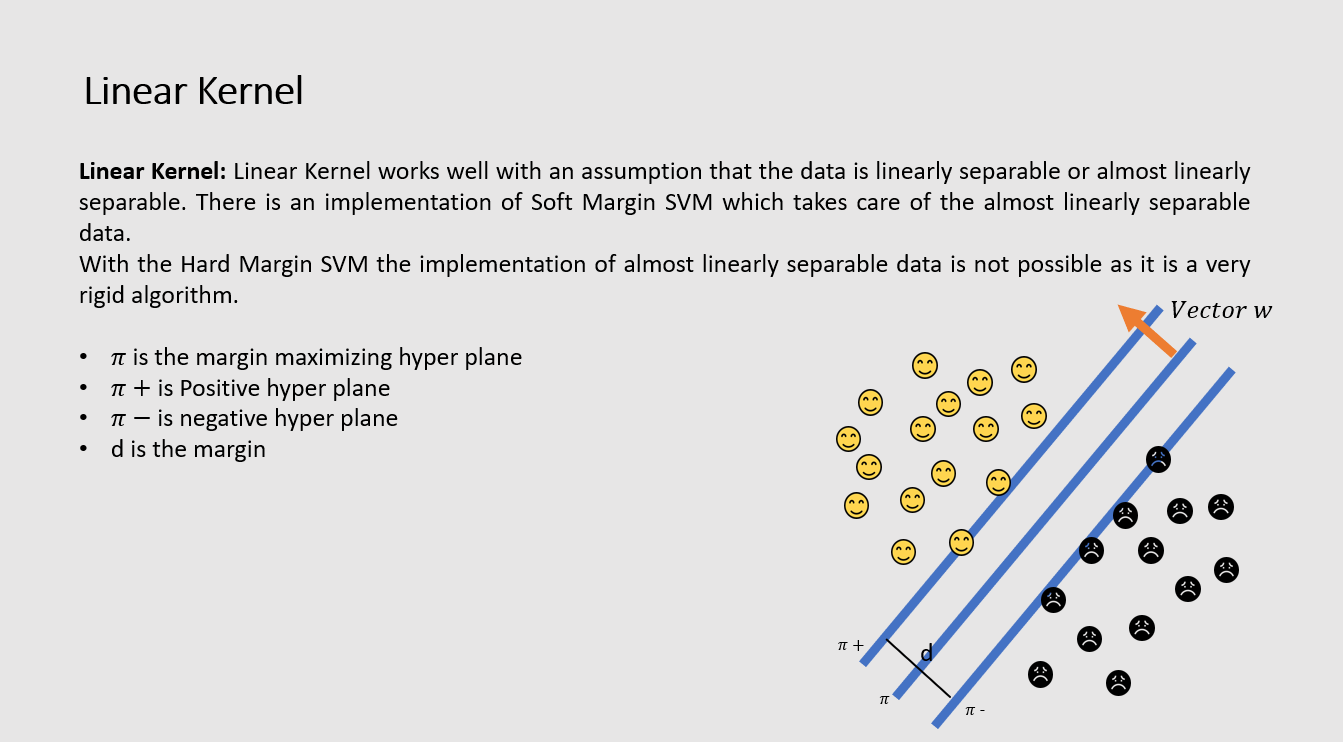

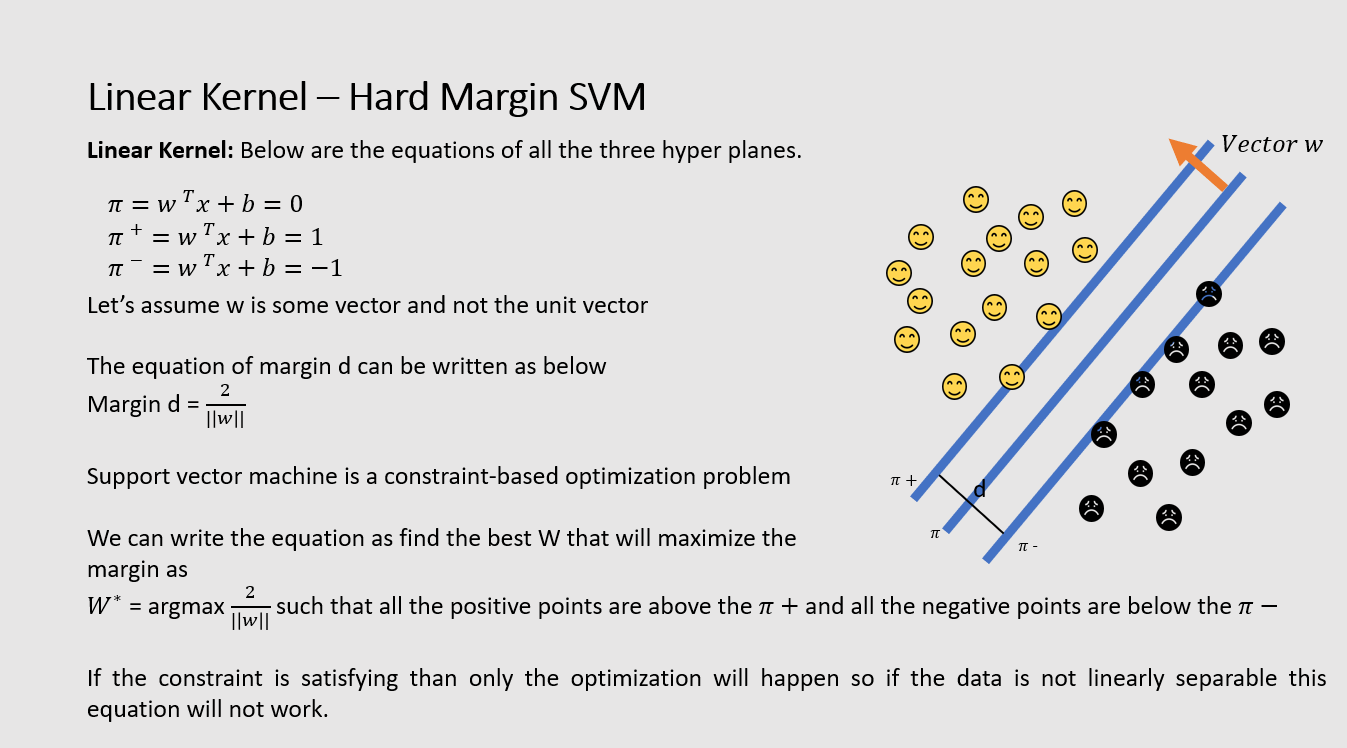

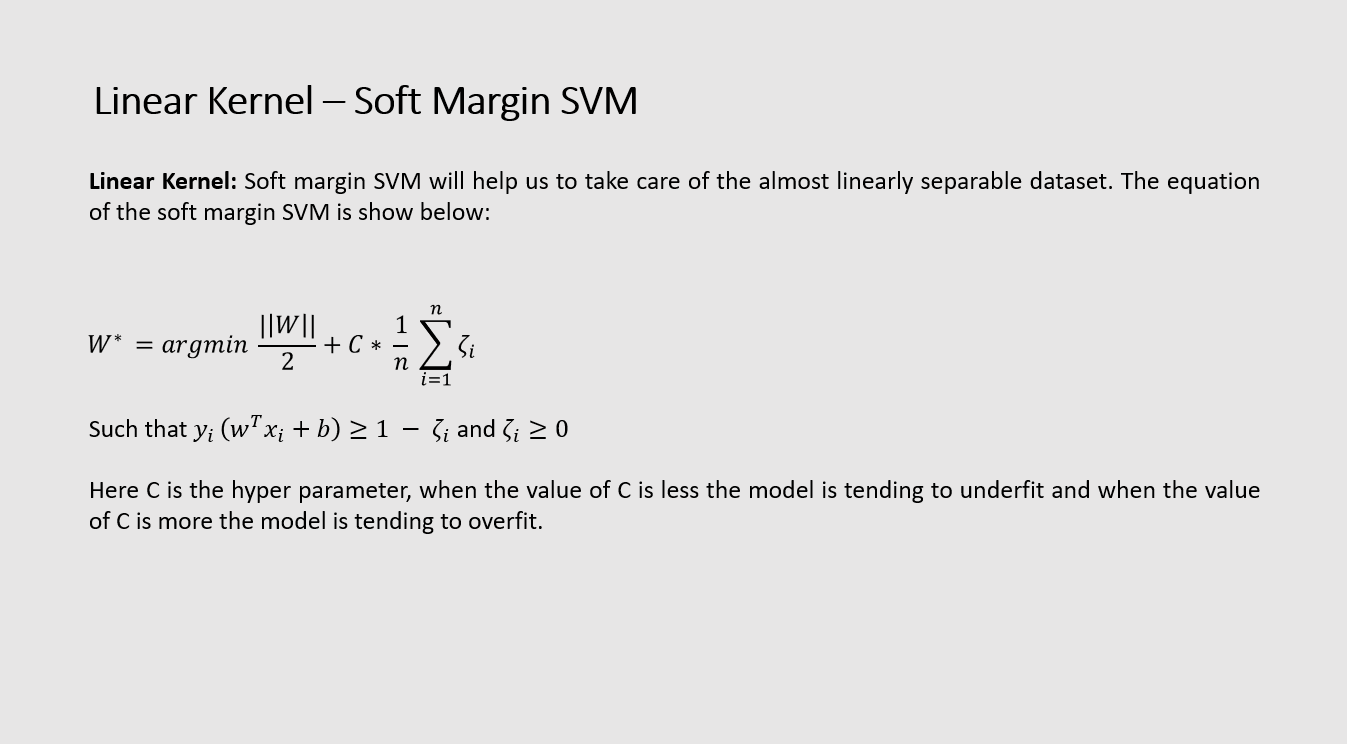

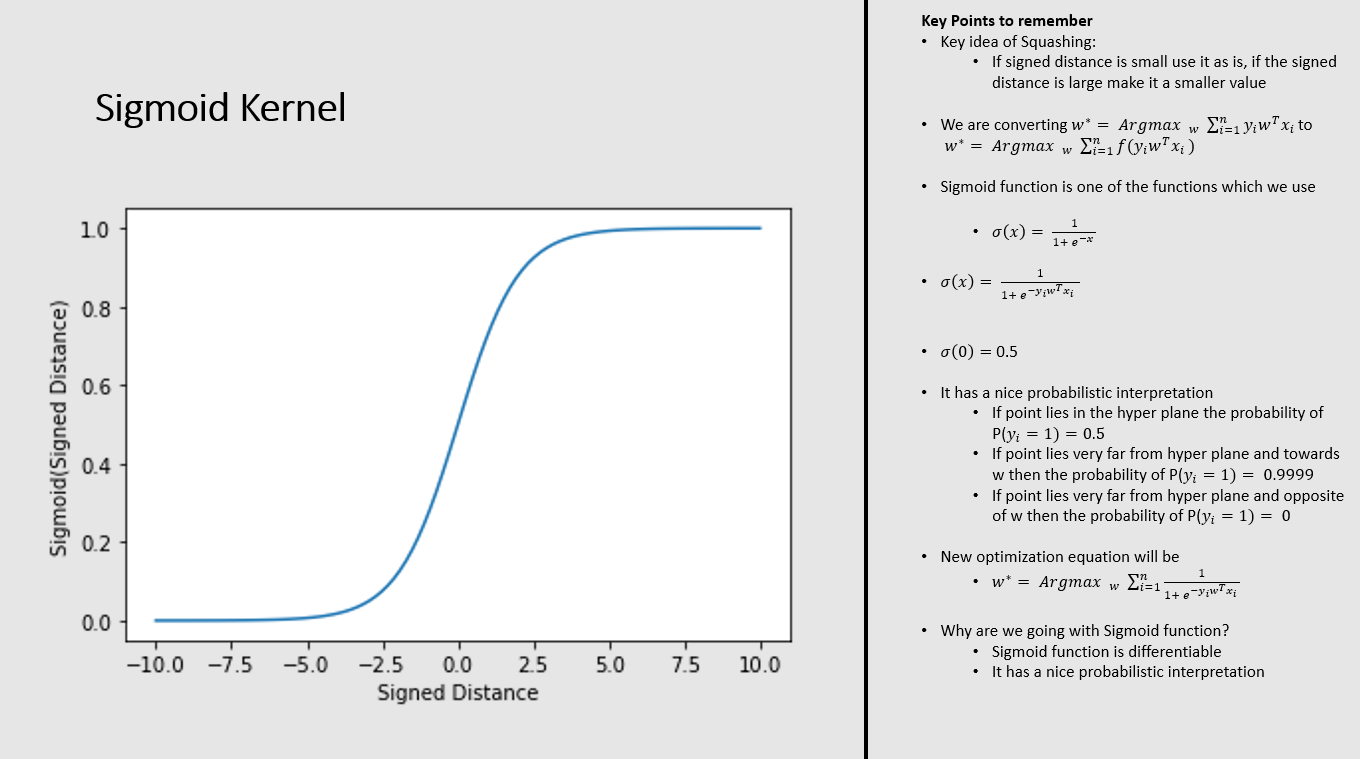

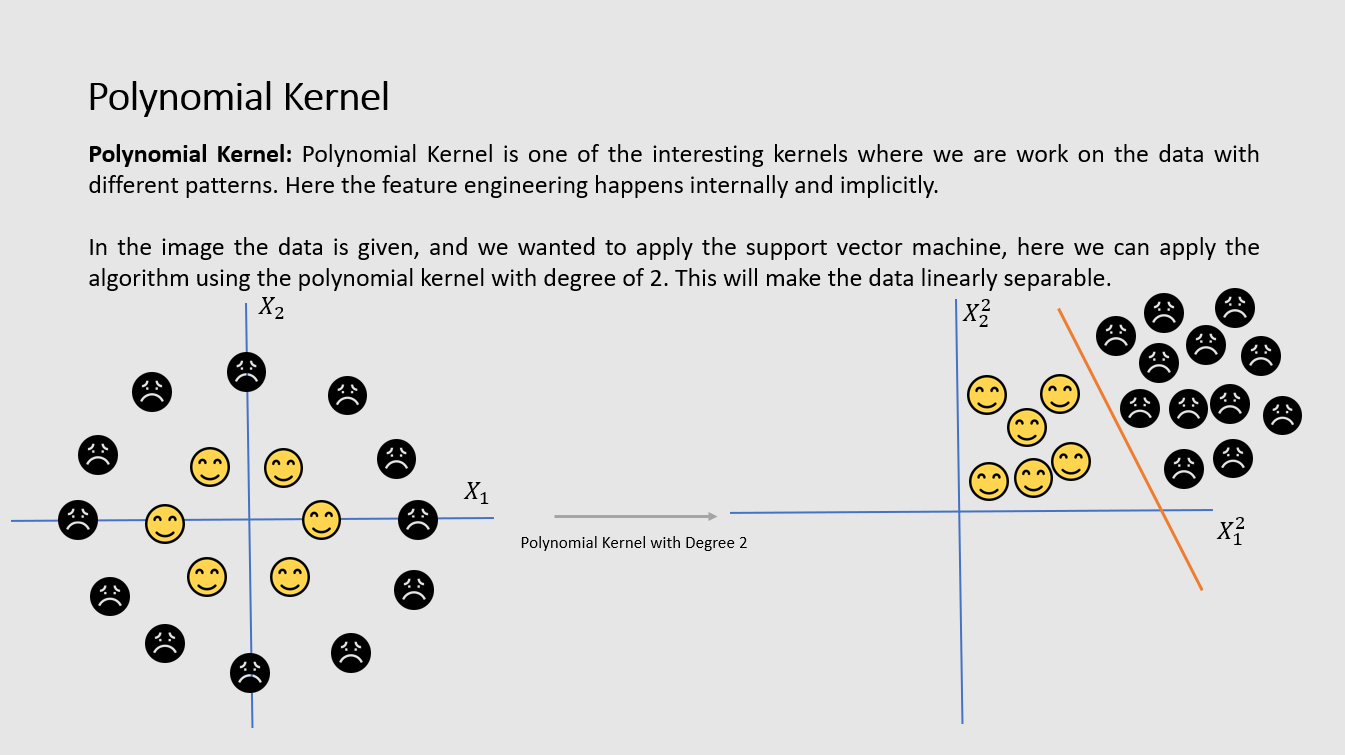

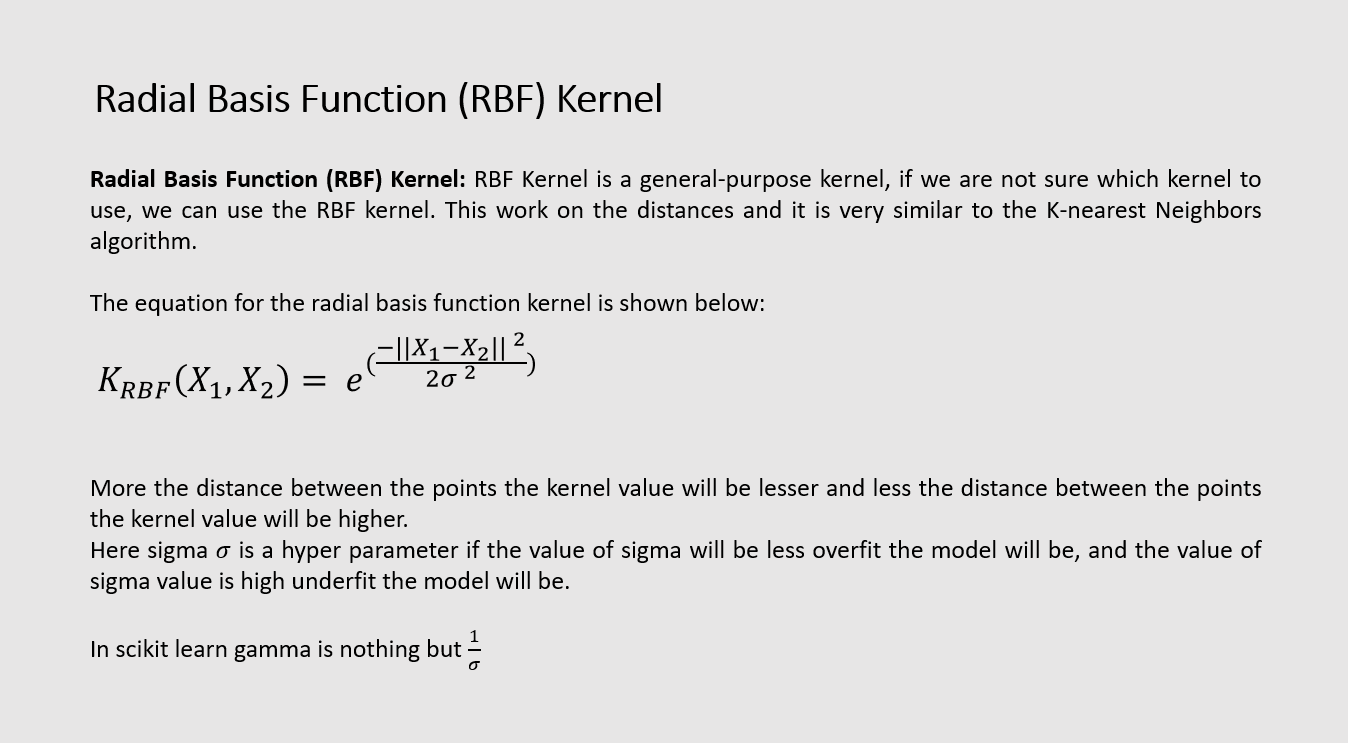

<a id="sf"></a>
# 3.3. Different Hyper parameters for different kernels

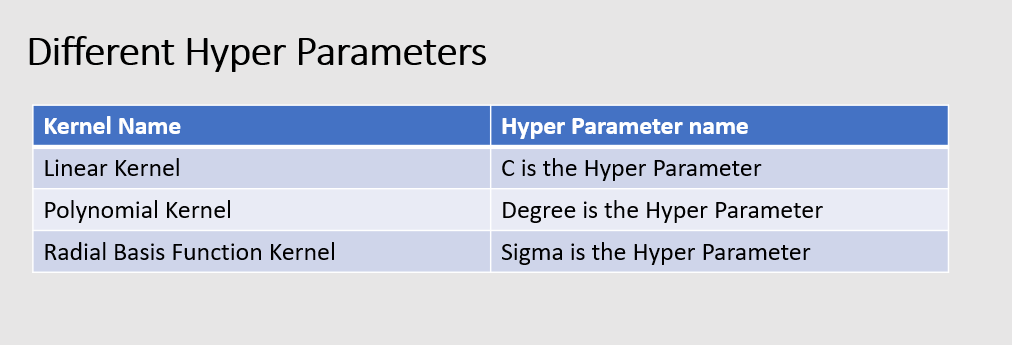

<a id="sf"></a>
# 3.4. How the value of C, Gamma will impact the model (Overfitting and Underfitting)

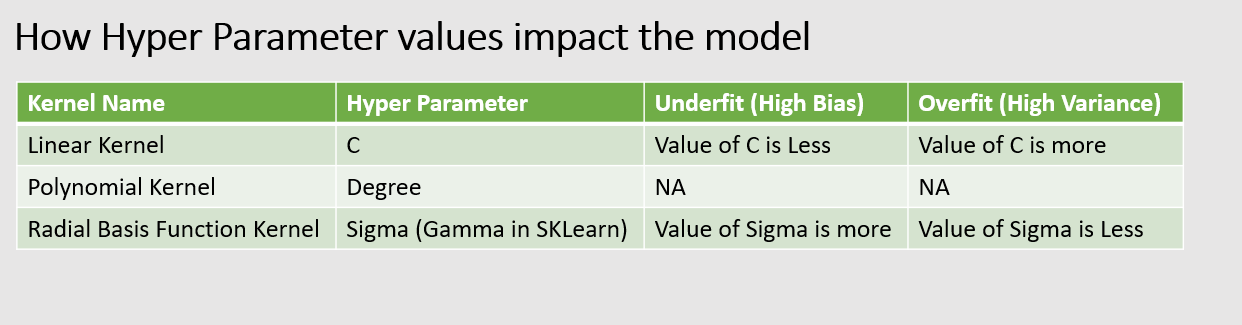

<a id="sd"></a>
# 4. Splitting the data into Train and Test

In [13]:
dataset

,SequenceName,MCG,GVH,ALM,MIT,ERL,POX,VAC,NUC,YeastType
0,2,1.026911,-0.228006,0.607699,-0.868168,-0.088936,-0.033501,0.691290,-0.597676,1
1,3,0.390102,-0.623306,0.445695,-0.512732,-0.088936,29.849623,-0.109737,-0.597676,0
2,42,0.117184,-0.129181,0.931709,-0.246155,-0.088936,-0.033501,1.332111,0.384292,1
3,4,-0.610599,-0.722131,1.093713,-0.690450,-0.088936,-0.033501,1.332111,0.056970,0
4,5,-0.337680,-0.722131,0.121685,-0.157296,-0.088936,-0.033501,0.531084,-0.188522,1
...,...,...,...,...,...,...,...,...,...,...
887,493,-0.792544,-1.413906,1.741732,1.619882,-0.088936,-0.033501,-0.910764,-1.497813,0
888,494,-0.792544,-0.623306,2.065742,1.086729,-0.088936,-0.033501,-1.070969,-1.497813,0
889,868,0.026211,-0.326831,1.255718,1.531023,-0.088936,-0.033501,-0.269942,1.448091,1
890,869,-0.337680,-0.623306,1.093713,-0.601591,-0.088936,-0.033501,0.531084,0.793446,1


In [14]:
#Splitting all the independent variables in one array
x = dataset.iloc[:,1:9].values 

In [15]:
#Splitting the dependent variable in one array
y = dataset.iloc[:,-1].values

In [16]:
#Splitting the dataset into train and test based on the 70-30 ratio
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30)

<a id="model"></a>
# 5. Creating the model on training dataset

In [17]:
#Applying the SVM on the training dataset
from sklearn.svm import SVC
SVMModel_ini = SVC()
SVMModel_ini.fit(x_train,y_train)

SVC()

<a id="test"></a>
# 6. Run the model on the Test Dataset

In [18]:
#Running the model on the test dataset
y_pred_ini = SVMModel_ini.predict(x_test)

<a id="acc"></a>
# 7. Check the accuracy of the model

There are various ways to check the accuracy of the classification model we are going to use all the ways to check the accuracies 

In [19]:
#Importing all the functions to for checking the accuracies
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve, accuracy_score, log_loss

<a id="accscore"></a>
# 7.1. Accuracy Score

In [20]:
#Using accuracy score we are checking the accuracy on the testing dataset
accuracy_score(y_test,y_pred_ini)

0.6791044776119403

<a id="cm"></a>
# 7.2. Confusion Matrix

C:\Users\rahul\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


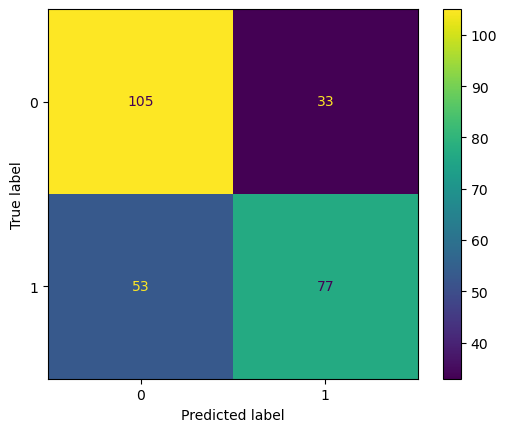

In [21]:
#Using confusion matrix we are checking the accuracy on the testing dataset
plot_confusion_matrix(SVMModel_ini,x_test,y_test)

<a id="roc"></a>
# 7.3. RO Curve

C:\Users\rahul\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


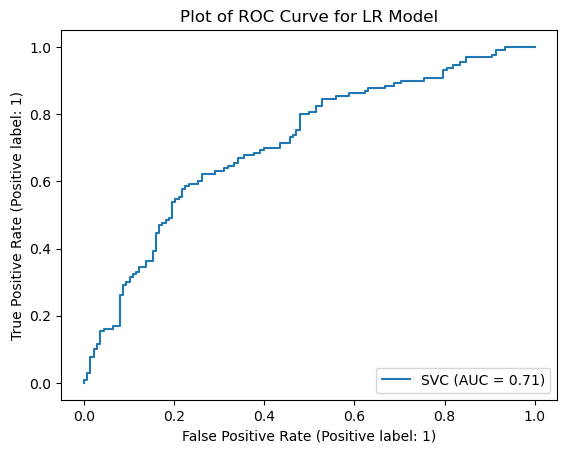

In [22]:
#Using ROC Curve we are checking the accuracy on the testing dataset
plot_roc_curve(SVMModel_ini, x_test, y_test)
plt.title("Plot of ROC Curve for LR Model")
plt.show()

<a id="f1score"></a>
# 7.4. F1 Score

In [23]:
#Using F1 Score we are checking the accuracy on the testing dataset
target_names= ["Negative(0)","Positive(1)"]
# Classification Report
print(classification_report(y_test,SVMModel_ini.predict(x_test),target_names=target_names))

              precision    recall  f1-score   support

 Negative(0)       0.66      0.76      0.71       138
 Positive(1)       0.70      0.59      0.64       130

    accuracy                           0.68       268
   macro avg       0.68      0.68      0.68       268
weighted avg       0.68      0.68      0.68       268



<a id="logloss"></a>
# 7.5. Log Loss

In [24]:
#Using Logloss we are checking the accuracy on the testing dataset
log_loss(y_test,SVMModel_ini.predict(x_test))

11.083437151781771

<a id="overunder"></a>
# 8. Comparing the Training and Testing Accuracies

In [25]:
#Storing the predicted values of training dataset in y_pred_train
y_pred_train = SVMModel_ini.predict(x_train)

In [26]:
#Checking the accuracy of training dataset 
accuracy_score(y_train,y_pred_train)

0.7131410256410257

In [27]:
#Checking the accuracy of testing dataset
accuracy_score(y_test,y_pred_ini)

0.6791044776119403

**Conclusion:** As there is very less difference between the accuracy of training and testing dataset we are good to go with the model

<a id="kfcv"></a>
# 9. Applying Grid Search Cross Validation to find the best value of Hyper Parameters

In [32]:
#Using Grid Search cross validation technique we will find the best value of hyper parameters - 
#Here we are finding the best kernel
from sklearn.model_selection import GridSearchCV
parameters = [ {'kernel': ['rbf','poly','sigmoid']}]
grid_search = GridSearchCV(estimator = SVMModel_ini,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(x_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [33]:
best_parameters

{'kernel': 'rbf'}

In [35]:
#Using Grid Search cross validation technique we will find the best value of hyper parameters - 
#As the best kernel is RBF now we will fine tune the value of gamma
from sklearn.model_selection import GridSearchCV
parameters = [ {'kernel': ['rbf'], 'gamma':[0.1,1,10,100,], 'C':[0.01,0.1,1,10,100]}]
grid_search = GridSearchCV(estimator = SVMModel_ini,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(x_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [36]:
#We are finalizing the best values as 'RBF' as kernel and 0.1 as the value of gamma
best_parameters

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [37]:
#Applying the SVM on the training dataset
from sklearn.svm import SVC
SVMModel_tuned = SVC(kernel='rbf',gamma=1, C=1)
SVMModel_tuned.fit(x_train,y_train)

SVC(C=1, gamma=1)

In [39]:
#Running the model on the test dataset
y_pred_tuned = SVMModel_tuned.predict(x_test)

In [40]:
#Using accuracy score we are checking the accuracy on the testing dataset
accuracy_score(y_test,y_pred_tuned)

0.6417910447761194

In [41]:
#Running the model on the train dataset
y_pred_train = SVMModel_tuned.predict(x_train)

In [43]:
#Using accuracy score we are checking the accuracy on the train dataset
accuracy_score(y_train,y_pred_train)

0.8910256410256411

In [44]:
# create an empty dataframe to store the scores for various algorithms
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_auc_score, f1_score
score_card = pd.DataFrame(columns=['model_name','Accuracy Score','Precision Score','Recall Score','AUC Score','f1 Score'])

# append the result table for all performance scores

def update_score_card(y_test,y_pred,model_name):

    # assign 'score_card' as global variable
    global score_card
    
    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    score_card = score_card.append({'model_name':model_name,
                                    'Accuracy Score' : accuracy_score(y_test, y_pred),
                                    'Precision Score': precision_score(y_test, y_pred),
                                    'Recall Score': recall_score(y_test, y_pred),
                                    'AUC Score': roc_auc_score(y_test, y_pred),
                                    'f1 Score': f1_score(y_test, y_pred)}, 
                                    ignore_index = True)

In [45]:
update_score_card(y_test,y_pred_ini,'initial_model')

C:\Users\rahul\AppData\Local\Temp\ipykernel_27680\1828073584.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_card = score_card.append({'model_name':model_name,


In [46]:
update_score_card(y_test,y_pred_tuned,'tuned_model')

C:\Users\rahul\AppData\Local\Temp\ipykernel_27680\1828073584.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_card = score_card.append({'model_name':model_name,


In [47]:
score_card

,model_name,Accuracy Score,Precision Score,Recall Score,AUC Score,f1 Score
0,initial_model,0.679104,0.700,0.592308,0.676589,0.641667
1,tuned_model,0.641791,0.625,0.653846,0.642140,0.639098


**Interpretation: Initial model is looking bit better than the tuned model, also if we see the model which was tuned there is a good difference between the training and testing accuracies and it implies that there is a probable overitting happening in the model. This may happen due to the lesser volume of the data.**